# Data Eng 300 Homework 3

#### Jonathan Wu

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
!curl https://raw.githubusercontent.com/mosesyhc/de300-2025sp-class/refs/heads/main/agnews_clean.csv -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.2M  100 33.2M    0     0  8527k      0  0:00:03  0:00:03 --:--:-- 8526k


In [3]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .master("local[*]")
         .appName("AG news")
         .getOrCreate()
        )

agnews = spark.read.csv("agnews_clean.csv", inferSchema=True, header=True)

# turning the second column from a string to an array
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType
agnews = agnews.withColumn('filtered', F.from_json('filtered', ArrayType(StringType())))

In [4]:
# each row contains the document id and a list of filtered words
agnews.show(5, truncate=30)

+---+------------------------------+
|_c0|                      filtered|
+---+------------------------------+
|  0|[wall, st, bears, claw, bac...|
|  1|[carlyle, looks, toward, co...|
|  2|[oil, economy, cloud, stock...|
|  3|[iraq, halts, oil, exports,...|
|  4|[oil, prices, soar, time, r...|
+---+------------------------------+
only showing top 5 rows



In [5]:
D = agnews.count()
D

127600

We want for each document find the percentage of t in the document

In [6]:
# For each document grab the filtered column
for_tf = agnews.select("filtered")
# In each of the documents, explode so we get the words and then explode again to get the letters
tf_word = for_tf.select(F.explode(for_tf.filtered).alias("word"))
tf_word.show()

+---------+
|     word|
+---------+
|     wall|
|       st|
|    bears|
|     claw|
|     back|
|    black|
|  reuters|
|  reuters|
|    short|
|  sellers|
|     wall|
|   street|
|dwindling|
|     band|
|    ultra|
|   cynics|
|   seeing|
|    green|
|  carlyle|
|    looks|
+---------+
only showing top 20 rows



In [7]:
# Keep the column using .select "_c0",
# previous column was bad because it doesn't separate wall st and carlyle
explode_words = agnews.select("_c0", F.explode("filtered").alias("word"))
# Make everything lowercase and then explode into letter
letters = explode_words.select("_c0",
                               F.explode(F.split(F.lower(explode_words.word), "")).alias("letter"))
letters.show()

+---+------+
|_c0|letter|
+---+------+
|  0|     w|
|  0|     a|
|  0|     l|
|  0|     l|
|  0|     s|
|  0|     t|
|  0|     b|
|  0|     e|
|  0|     a|
|  0|     r|
|  0|     s|
|  0|     c|
|  0|     l|
|  0|     a|
|  0|     w|
|  0|     b|
|  0|     a|
|  0|     c|
|  0|     k|
|  0|     b|
+---+------+
only showing top 20 rows



In [8]:
# Count total letters and number of 't's
letter_counts = letters.groupBy("_c0").agg(
    F.count("letter").alias("total_letters"),
    # when is something ChatGPT recommended using and it seems to work
    F.sum(F.when(letters.letter == "t", 1).otherwise(0)).alias("t_count")
)

letter_counts.show()

+----+-------------+-------+
| _c0|total_letters|t_count|
+----+-------------+-------+
| 148|          186|     13|
| 463|          138|      6|
| 471|          160|     17|
| 496|          185|      5|
| 833|           79|      6|
|1088|          105|      8|
|1238|          129|     13|
|1342|          143|     15|
|1580|          144|      6|
|1591|          168|     10|
|1645|          129|     10|
|1829|          197|     18|
|1959|          150|      6|
|2122|          162|      8|
|2142|          136|     10|
|2366|          114|      9|
|2659|          154|      7|
|2866|           96|      7|
|3175|          156|      9|
|3749|          122|      3|
+----+-------------+-------+
only showing top 20 rows



In [9]:
# Compute percentage of 't'
letter_count = letter_counts.withColumn(
    "tf", letter_counts.t_count / letter_counts.total_letters
)

letter_count.show()

+----+-------------+-------+--------------------+
| _c0|total_letters|t_count|                  tf|
+----+-------------+-------+--------------------+
| 148|          186|     13| 0.06989247311827956|
| 463|          138|      6|0.043478260869565216|
| 471|          160|     17|             0.10625|
| 496|          185|      5| 0.02702702702702703|
| 833|           79|      6|  0.0759493670886076|
|1088|          105|      8|  0.0761904761904762|
|1238|          129|     13| 0.10077519379844961|
|1342|          143|     15|  0.1048951048951049|
|1580|          144|      6|0.041666666666666664|
|1591|          168|     10| 0.05952380952380952|
|1645|          129|     10| 0.07751937984496124|
|1829|          197|     18| 0.09137055837563451|
|1959|          150|      6|                0.04|
|2122|          162|      8| 0.04938271604938271|
|2142|          136|     10| 0.07352941176470588|
|2366|          114|      9| 0.07894736842105263|
|2659|          154|      7|0.045454545454545456|


In [10]:
# sanity check that number of rows is correct
letter_count.count()

127600

In [11]:
tf_list = letter_count.select("tf").collect()
tf_list = [row.tf for row in tf_list]

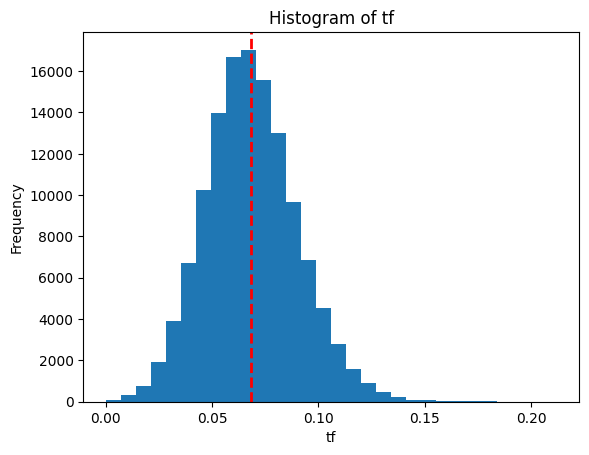

In [12]:
tf_mean = np.mean(tf_list)
plt.hist(tf_list, bins=30)
plt.xlabel("tf")
plt.ylabel("Frequency")
plt.axvline(tf_mean, color="red", linestyle="dashed", linewidth=2)
plt.title("Histogram of tf")
plt.show()

In [13]:
# count the number of documents with at least 1 t or t_count >=1
documents_with_t = letter_count.filter(letter_count.t_count >= 1).count()
documents_with_t
# I'm assuming base 10 log
# https://blog.marketmuse.com/glossary/inverse-document-frequency-idf-definition/#:~:text=IDF%20is%20a%20way%20of,the%20collection%20containing%20the%20term.
idf = math.log(D / documents_with_t, 10)
idf

0.00018383123680510127

In [14]:
# tf * idf
tf_idf_measured = letter_count.withColumn(
    "tf_idf", letter_count.tf * idf
)

tf_idf_measured.show(5)

+---+-------------+-------+--------------------+--------------------+
|_c0|total_letters|t_count|                  tf|              tf_idf|
+---+-------------+-------+--------------------+--------------------+
|148|          186|     13| 0.06989247311827956|1.284841977670062...|
|463|          138|      6|0.043478260869565216|7.992662469787012E-6|
|471|          160|     17|             0.10625|1.953206891054201E-5|
|496|          185|      5| 0.02702702702702703|4.968411805543278E-6|
|833|           79|      6|  0.0759493670886076|1.396186608646338...|
+---+-------------+-------+--------------------+--------------------+
only showing top 5 rows



In [15]:
tf_idf_list = tf_idf_measured.select("tf_idf").collect()
tf_idf_list = [row.tf_idf for row in tf_idf_list]
tf_idf_mean = np.mean(tf_idf_list)
tf_idf_mean

np.float64(1.2593954799281428e-05)

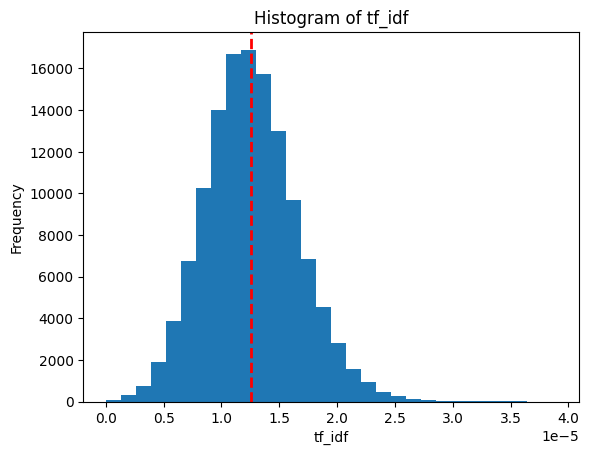

In [16]:
plt.hist(tf_idf_list, bins=30)
plt.xlabel("tf_idf")
plt.ylabel("Frequency")
plt.axvline(tf_idf_mean, color="red", linestyle="dashed", linewidth=2)
plt.title("Histogram of tf_idf")
plt.show()

Histogram looks good, it is the same histogram as the previous one except for the x-axis being scaled larger (from 0 to about 4 rather than from 0 to 0.25)

### Map Reduce Functions


In [17]:
def map_idf(df):
  # Turn everything into letters
  letters = (
    df.select("_c0",
        F.explode(  # explode words
            F.transform("filtered",lambda w: F.split(F.lower(w), "") )
            ).alias("word"))
    .select("_c0", F.explode("word").alias("letter"))
  )
  return letters

In [ ]:
def shuffle_idf(letters):
  # Aggregate by letters and counts of t
  letter_counts = (letters.groupBy("_c0").agg(
    F.count("letter").alias("total_letters"),
    F.sum(F.when(letters.letter == "t", 1).otherwise(0)).alias("t_count")
  ))
  # Find tf
  letter_count = (letter_counts.withColumn(
    "tf", letter_counts.t_count / letter_counts.total_letters
  ))
  return letter_count

In [ ]:
def reduce_idf(letter_count):
  # Find idf
  idf = math.log(D / letter_count.filter(letter_count.t_count >= 1).count(), 10)
  # Find tf_idf
  tf_idf_measured = (letter_count.withColumn(
    "tf_idf", letter_count.tf * idf
  ))
  return tf_idf_measured

In [ ]:
# D is calculated above and is consistent
map_idf_df = map_idf(agnews)
sort_idf_df = shuffle_idf(map_idf_df)
reduce_idf_df = reduce_idf(sort_idf_df)
reduce_idf_df.show(5)


+---+-------------+-------+--------------------+--------------------+
|_c0|total_letters|t_count|                  tf|              tf_idf|
+---+-------------+-------+--------------------+--------------------+
|148|          186|     13| 0.06989247311827956|1.284841977670062...|
|463|          138|      6|0.043478260869565216|7.992662469787012E-6|
|471|          160|     17|             0.10625|1.953206891054201E-5|
|496|          185|      5| 0.02702702702702703|4.968411805543278E-6|
|833|           79|      6|  0.0759493670886076|1.396186608646338...|
+---+-------------+-------+--------------------+--------------------+
only showing top 5 rows



### Done with an rdd with .apply

In [31]:
def map_idf(row):
  # Turn everything into letters
  row_dict = row.asDict()
  doc = row_dict["_c0"]
  words = row_dict["filtered"]
  for word in words:
    letters = list(word.lower())
    for letter in letters:
      yield (doc, letter)

def shuffle_idf(data):
    # data: list of (doc, letter) tuples

    total_letters = {}
    t_counts = {}

    for doc, letter in data:
      if doc not in total_letters.keys():
        total_letters[doc] = 0
        t_counts[doc] = 0
      total_letters[doc] += 1
      if letter == 't':
          t_counts[doc] += 1

    # Calculate tf per doc (only docs that have t)
    tf_per_doc = {}
    for doc in total_letters.keys():
      if doc in t_counts.keys():
        tf_per_doc[doc] = t_counts[doc] / total_letters[doc]
      else:
        tf_per_doc[doc] = 0

    return tf_per_doc
def reduce_idf(tf_per_doc):
    # tf_per_doc: dict doc -> tf for 't'
    docs_with_t = [tf_per_doc[doc] for doc in tf_per_doc.keys() if tf_per_doc[doc] > 0]
    len_t = len(docs_with_t)
    idf = math.log(D / len_t, 10)
    print(idf)

    tf_idf_scores = [tf * idf for tf in tf_per_doc.values()]
    return tf_idf_scores

In [32]:
map_idf_df = agnews.rdd.flatMap(map_idf).collect()
sort_idf_df = shuffle_idf(map_idf_df)
reduce_idf_df = reduce_idf(sort_idf_df)
#tf_idf = reduce_idf_df.map(lambda x: x[3]).collect()
#reduce_idf_df
#sort_idf_df.collect()

0.00018383123680510127


In [ ]:
sort_idf_df = shuffle_idf(map_idf_df)
reduce_idf_df = reduce_idf(sort_idf_df)

In [33]:
reduce_idf_df[0:5]

[1.3545459554060093e-05,
 1.5645211642987343e-05,
 1.2855331245111977e-05,
 1.6250275076694033e-05,
 1.0813602165005957e-05]

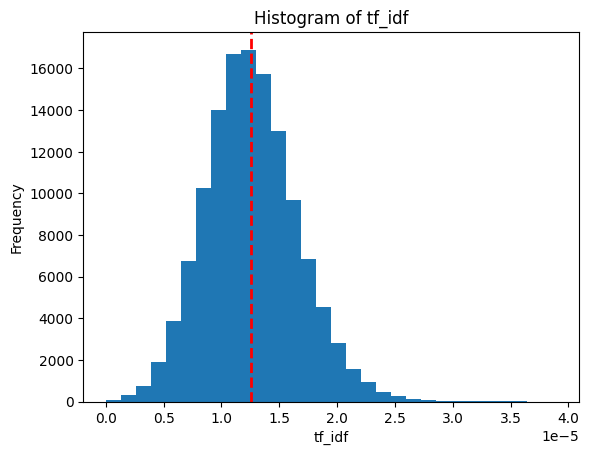

In [34]:
plt.hist(reduce_idf_df, bins=30)
plt.xlabel("tf_idf")
plt.ylabel("Frequency")
plt.axvline(tf_idf_mean, color="red", linestyle="dashed", linewidth=2)
plt.title("Histogram of tf_idf")
plt.show()

##Part 2 SVM

In [35]:
!curl https://raw.githubusercontent.com/mosesyhc/de300-2025sp-class/refs/heads/main/w.csv -O
!curl https://raw.githubusercontent.com/mosesyhc/de300-2025sp-class/refs/heads/main/bias.csv -O
!curl https://raw.githubusercontent.com/mosesyhc/de300-2025sp-class/refs/heads/main/data_for_svm.csv -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1391  100  1391    0     0   2091      0 --:--:-- --:--:-- --:--:--  2091
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    22  100    22    0     0     43      0 --:--:-- --:--:-- --:--:--    43
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 61.9M  100 61.9M    0     0  14.4M      0  0:00:04  0:00:04 --:--:-- 14.4M


In [ ]:
# This is an example to read the files. But you should consider using pyspark directly.
# *Make sure you are not assuming a header*!!
import pandas as pd
data_svm = pd.read_csv('data_for_svm.csv', header=None)
w = pd.read_csv('w.csv', header=None)
bias = pd.read_csv('bias.csv', header=None)

In [36]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .master("local[*]")
         .appName("SVM")
         .getOrCreate()
        )

data_svm = spark.read.csv("data_for_svm.csv", inferSchema=True, header=False)
w = spark.read.csv("w.csv", inferSchema=True, header=False)
bias = spark.read.csv("bias.csv", inferSchema=True, header=False)


In [37]:
data_svm.show(5)

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|_c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|_c41|_c42|_c43|_c44|_c45|_c46|_c47|_c48|_c49|_c50|_c51|_c52|_c53|_c54|_c55|_c56|_c57|_c58|_c59|_c60|_c61|_c62|_c63|_c64|
+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
| -1| -1|  1|  1| -1|  1|  1|  1|  1| -1|   1|   

In [38]:
w.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------

In [39]:
bias.show(5)

+--------------------+
|                 _c0|
+--------------------+
|1.495661647902824E-4|
+--------------------+



Find ||w||^2 and 1/n. set lambda and b

In [40]:
w_list = w.collect()[0]
w_list2 = list(w_list)
w_list2
w2 = np.sum(np.array(w_list2))
w2

np.float64(0.0036068090552452414)

In [41]:
n_inv = 1/data_svm.count()
lam = 1
b = bias.collect()[0][0]
b

0.0001495661647902824

map pred or $1 - y_i(w^Tx_i+b)$

In [53]:
# Take each column in data_svm and w. multiple each column together where
# x[last column] * (w[column] * x[row][column] + bias)
def compute_y_pred(row):
  features = row[:-1]
  label = row[-1]
  weights = w_list2
  z = sum(f * w for f,w in zip(features, weights)) + b
  y_pred = 1 - z*label
  return row + (y_pred,)

rdd_svm = data_svm.rdd.map(compute_y_pred)

#svm_pred = data_svm.map(compute_y_pred)
#svm_pred.take(5)

In [50]:
# return an rdd with only the last two columns multiplied together
def loss_calc(rdd):
  y_hat = rdd[-1]
  y_pred = rdd[-2]
  return 1 - y_hat * y_pred

preds = rdd_svm.map(loss_calc).sum()
L = lam * w2 + n_inv * preds
L

np.float64(1.006673132980288)

In [59]:
from pyspark.sql.functions import col

# Get all column names
all_columns = data_svm.columns
feature_columns = all_columns[:-1]
label_column = all_columns[-1]

# Select features and label
X = data_svm.select(*feature_columns)
y = data_svm.select(label_column)

def loss_SVM(w, b, X, y):
  w_list = w.collect()[0]
  w2 = np.sum(np.array(list(w_list)))
  n_inv = 1/X.count()
  lam = 1
  b = bias.collect()[0][0]

  def compute_y_pred(row):
    features = row[:-1]
    label = row[-1]
    weights = w_list2
    z = sum(f * w for f,w in zip(features, weights)) + b
    y_pred = 1 - z*label
    return row + (y_pred,)

  rdd_svm = X.rdd.map(compute_y_pred)
  xy_rdd = rdd_svm.zip(y.rdd)

  def loss_calc(rdd):
    svm_row, y_row = rdd
    y_pred = svm_row[-1]  # last element of svm_row
    y_hat = y_row[0]
    return 1 - y_hat * y_pred

  preds = xy_rdd.map(loss_calc).sum()
  L = lam * w2 + n_inv * preds
  return L
L = loss_SVM(w, b, X, y)
L

np.float64(1.0064283896862403)